# Multiclass Neural Network

This notebook is for personal practice implementing a neural network from scratch using Numpy. The neural network learns to classify points in the plane into discrete categories by training on a toy dataset generated below. It features ADAM optimization and L2 regularization.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Toy Dataset

In [2]:
samples = 10000
categories = 3

### Create a spiral data set in R^2 from normal distributions.


In [3]:
def spiral(s, t, k, K):
  a_1 = (2/2) / categories
  a_2 = 0
  b_1 = 1
  b_2 = 5
  s = a_1 * s + a_2
  t = b_1 * t + b_2
  x = t * np.cos(t+s + 2*k*np.pi/K)
  y = t * np.sin(t+s + 2*k*np.pi/K)
  return x, y

xs = []
for i in range(categories):
  x = np.random.randn(2,samples)
  x[0,:], x[1,:] = spiral(x[0,:], x[1,:], i, categories)
  xs.append(x)

ys = []
ys_num = []
for i in range(categories):
  y = np.zeros((categories, samples))
  y_num = np.full((1, samples), i)
  y[i,:] = 1
  ys.append(y)
  ys_num.append(y_num)

In [4]:
X_0 = np.concatenate(xs, axis=1)
Y_0 = np.concatenate(ys, axis=1)
shuffle = np.random.permutation(samples * categories)

X = X_0[:,shuffle]
Y = Y_0[:,shuffle]
Y_labels = np.argmax(Y, axis=0)

In [5]:
train_test_ratio = .9
M = int(train_test_ratio * samples * categories)
X_train, X_test, Y_train, Y_test = X[:,:M], X[:,M:], Y[:,:M], Y[:,M:]

### Function to plot the data, with colors

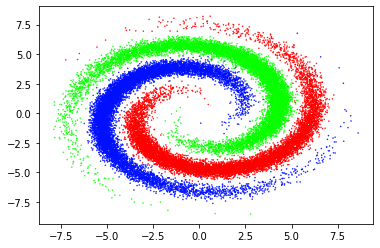

In [6]:
colors = plt.cm.hsv(np.linspace(0, 1, categories, endpoint=False))
def getColor(k): return colors[k]

def plot(X, labels, s, ax = None):
  if ax == None:
    return plt.scatter(X[0,:],X[1,:], c=getColor(labels), alpha=1, s=s)
  return ax.scatter(X[0,:],X[1,:], c=getColor(labels), alpha=1, s=s)

plot(X,np.argmax(Y, axis=0), .25)

## Neural Network

### Mathematical functions

In [7]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

def sigmoid_prime(x, a):
  return a*(1-a)

def tanh(z):
  return 2*sigmoid(2*z) - 1

def tanh_prime(z, a):
  return (1 + a)*(1 - a)

def softmax(X):
  return np.exp(X)/np.sum(np.exp(X), axis=0)

def logloss(y_1,y_2):
  return -y_1 * np.log(y_2)

functions = {"sigmoid": sigmoid, "tanh": tanh, "softmax": softmax}
derivatives = {"sigmoid": sigmoid_prime, "tanh": tanh_prime}

### Neural Network Class

In [8]:
class network:
  def __init__(self, layer_dims, hidden_activation_functions = None, learning_rate = .01):
    # To avoid divisions by zero when necessary
    self.epsilon = 10**-8

    self.layer_dims = layer_dims

    # If the hidden layer activation functions are not specified, assume tanh
    # The final layer is always the softmax function
    # The cost function is always m
    if not hidden_activation_functions == None:
      self.activation_functions = hidden_activation_functions
    else:
      self.activation_functions = [None]
      for k in range(1,len(layer_dims)-1):
        self.activation_functions.append("tanh")
    self.activation_functions.append("softmax")

    self.learning_rate = learning_rate

    self.initialize_parameters()
  
  def initialize_parameters(self):

    # Arrays of dictionaries are kept to facilitate the forwards and backwards passes
    # Each includes a dictionary for every layer (including the input layer)
    self.params = [{}]
    self.vs = [{}]
    self.ss = [{}]
    self.grads = [{}]
    self.caches = [{}]

    for l in range(1, len(self.layer_dims)):
      param = {}
      v = {}
      s = {}
      grad = {}
      cache = {}

      # Weights and biases
      # Weights are initialized to have 0 mean and variance 1/n, where n is the
      # size of the previous layer (Xavier initialization)
      param['W'] = 1/self.layer_dims[l-1] * np.random.randn(self.layer_dims[l],self.layer_dims[l-1])
      param['b'] = np.zeros((self.layer_dims[l],1))

      # Momentum and second moment moving averages
      v['W'] = np.zeros((self.layer_dims[l],self.layer_dims[l-1]))
      s['W'] = np.zeros((self.layer_dims[l],self.layer_dims[l-1]))
      v['b'] = np.zeros((self.layer_dims[l],1))
      s['b'] = np.zeros((self.layer_dims[l],1))

      self.params.append(param)
      self.vs.append(v)
      self.ss.append(s)
      self.grads.append(grad)
      self.caches.append(cache)
  
  def current_output(self):
    return self.caches[-1]['A']

  def forward_propagate(self, X):
    # Propagate an input forward through the network

    # All node activations will be stored in a cache for later use
    self.caches[0]['A'] = X

    for l in range(1, len(self.layer_dims)):
      A_prev = self.caches[l-1]['A']
      W = self.params[l]['W']
      b = self.params[l]['b']
      Z = np.dot(W, A_prev) + b

      # The output layer has a different activation function than the hidden layers
      A = functions[self.activation_functions[l]](Z)

      self.caches[l]['Z'] = Z
      self.caches[l]['A'] = A

  def cost(self, X, Y, A = None):
    # Compute the cost of an input given a target
    if A == None:
      self.forward_propagate(X)
      A = self.current_output()
    cost = np.mean(np.sum(logloss(Y,A), axis=0, keepdims=True))
    return cost
  
  def classify(self, X):
    # Classify an input
    self.forward_propagate(X)
    labels = np.argmax(self.current_output(), axis=0)
    return labels

  def accuracy(self, X, Y, A = None):
    # Compute the accuracy of the classification of an input
    if A == None:
      self.forward_propagate(X)
      A = self.current_output()
    labels = np.argmax(A, axis=0)
    truth = np.argmax(Y, axis=0)
    totals = np.sum(Y, axis=1).astype(int)
    counts = np.zeros(totals.shape).astype(int)
    for k in range(len(truth)):
      if labels[k] == truth[k]:
        counts[labels[k]] += 1
    accuracies = counts/totals

    for k in range(len(totals)):
      print("Category {}:".format(k))
      print("\tClassifed {} of {} samples correctly, for an accuracy of {}%.".format(counts[k],totals[k],round(100*accuracies[k],2)))
      print()
    
    count = np.sum(counts)
    total = np.sum(totals)
    accuracy = count/total
    print("Overall classified {} of {} samples correctly, for an accuracy of {}%.".format(count, total, round(100*accuracy,2)))
    return accuracy

  
  def backward_propagate_step(self, l, Y):
    # Propagate gradients backward through the network, using the current cache
    # This should not be called if forward_propagate has not been called at least once
    Z = self.caches[l]['Z']
    A = self.caches[l]['A']
    # The output layer has a different gradient than the hidden layers
    if l != len(self.layer_dims)-1:
      W_next = self.params[l+1]['W']
      DZ_next = self.grads[l+1]['DZ']
      DZ = np.dot(W_next.transpose(), DZ_next) * derivatives[self.activation_functions[l]](Z,A)
    else:
      DZ = A - Y  ###softmax is hardcoded currently! (need to allow arb activations still!)

    A_prev = self.caches[l-1]['A']
    m = A_prev.shape[1] # Number of samples in the last input (possibly a mini-batch)
      
    DW = 1/m*np.dot(DZ, A_prev.transpose())
    Db = np.mean(DZ, axis=1, keepdims=True)

    # Store the gradients for future use
    self.grads[l]['DZ'] = DZ
    self.grads[l]['DW'] = DW
    self.grads[l]['Db'] = Db
  
  def update_parameters_step(self, l, n, t, alpha, lambd=0, beta_1=0, beta_2=None):
    # Update the weights and biases using gradient descent
    # Optionally use regularization and moment optimization
    # n: number of samples (not mini-batch size)
    # t: current update count
    # alpha: learning rate
    # lambd: regularization parameter (defaults to no regularization)
    # beta_1: momentum optimization parameter (defaults to no momentum optimization)
    # beta_2: second moment optimization parameter (defaults to no second moment optimization)

    # Calculate momentum (if beta_1 = 0 then this reduces to just the gradient)
    VW = beta_1 * self.vs[l]['W'] + (1 - beta_1) * self.grads[l]['DW']
    Vb = beta_1 * self.vs[l]['b'] + (1 - beta_1) * self.grads[l]['Db']
    self.vs[l]['W'] = VW
    self.vs[l]['b'] = Vb
    if not beta_1 == 1:
      VW = VW / (1 - beta_1**(t+1))
      Vb = Vb / (1 - beta_1**(t+1))

    # The momentum-optimized adjustment
    deltaW = VW
    deltab = Vb

    # Calculate second moment
    if not beta_2 == None:
      SW = beta_2 * self.ss[l]['W'] + (1 - beta_2) * self.grads[l]['DW'] * self.grads[l]['DW']
      Sb = beta_2 * self.ss[l]['b'] + (1 - beta_2) * self.grads[l]['Db'] * self.grads[l]['Db']
      self.ss[l]['W'] = SW
      self.ss[l]['b'] = Sb
      if not beta_2 == 1:
        SW = SW / (1 - beta_2**(t+1))
        Sb = Sb / (1 - beta_2**(t+1))

      # The second-moment-optimized adjustment
      deltaW = deltaW / (np.sqrt(SW) + self.epsilon)
      deltab = deltab / (np.sqrt(Sb) + self.epsilon)
    
    self.params[l]['W'] = (1-alpha*lambd/n)*self.params[l]['W'] - alpha * deltaW
    self.params[l]['b'] = (1-alpha*lambd/n)*self.params[l]['b'] - alpha * deltab
        
  def model(self, X, Y, epochs = 1000, mini_batch_size = None, learning_rate = None, learning_rate_decay = .1, regularization = 0, momentum = 0, second_moment = None, update_every = 100, snapshots_on=[]):
      # Perform gradient descent

      n = X.shape[1] # Number of samples

      label_sets = []
      # A specific learning rate may be provided
      if learning_rate == None: learning_rate = self.learning_rate
      
      t = 0
      for k in range(epochs):
        if k % update_every == 0:
          cost = self.cost(X, Y)   
          print("Cost after {} epochs: {}".format(k, cost))
        if k in snapshots_on:
          label_sets.append(self.classify(X)) 

        if mini_batch_size != None:
          mini_batches = self.random_mini_batches(X, Y, mini_batch_size)
        else:
          mini_batches = (X,Y)
        
        for mini_batch in mini_batches:
          (mini_batch_X, mini_batch_Y) = mini_batch
          self.forward_propagate(mini_batch_X)
          for l in reversed(range(1,len(self.layer_dims))):
            self.backward_propagate_step(l, mini_batch_Y)
            self.update_parameters_step(l, n, t, learning_rate/(1+learning_rate_decay*k), regularization, momentum, second_moment)

        t += 1

      cost = self.cost(X, Y)
      label_sets.append(np.argmax(self.current_output(), axis=0))
      print("Cost after {} epochs: {}".format(k+1, cost))
      return label_sets

  def random_mini_batches(self, X, Y, mini_batch_size):
    # Divide up the input into mini-batches
    # Minibatches can speed up gradient descent
    n = X.shape[1] 
    mini_batches = []
    
    shuffle = list(np.random.permutation(n))
    shuffled_X = X[:, shuffle]
    shuffled_Y = Y[:, shuffle]

    num_complete_minibatches = int(n/mini_batch_size)
    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For when the mini-batch size does not divide the input size
    if n % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size :]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

## Testing

In [15]:
net = network([2,20,20,categories])

Cost after 0 epochs: 1.1036026517067277
Cost after 100 epochs: 0.009615614555994663
Cost after 200 epochs: 0.008486957389809422
Cost after 300 epochs: 0.007526235137184593
Cost after 400 epochs: 0.006760831764456265
Cost after 500 epochs: 0.00613836513415361
Cost after 600 epochs: 0.00566080198031143
Cost after 700 epochs: 0.005323942643040414
Cost after 800 epochs: 0.005073828607051806
Cost after 900 epochs: 0.004902117072220905
Cost after 1000 epochs: 0.004764972050121965


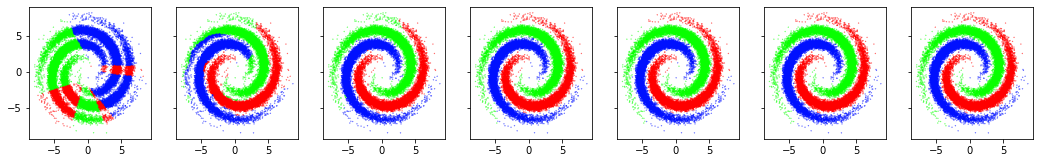

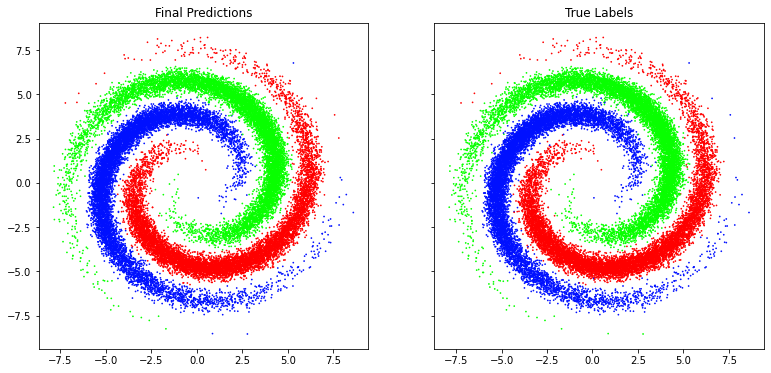

In [16]:
label_sets = net.model(X_train, Y_train, 1000, 128, .1, .5, .1, .9, .999, update_every=100, snapshots_on=[0,1,3,10,30,100,300,1000,3000,10000])

pointsize = .5
count = len(label_sets)
fig, axs = plt.subplots(1, count-1, sharex=True, sharey=True, figsize = (18, 17/(count-1)))
for k in range(count-1):
  plot(X_train, label_sets[k], pointsize/count, axs[k])
plt.show()
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize = (13,6))
axs[0].set_title('Final Predictions')
plot(X_train, label_sets[-1], pointsize, axs[0])
axs[1].set_title('True Labels')
plot(X_train, np.argmax(Y_train, axis=0), pointsize, axs[1])
plt.show()

In [17]:
net.accuracy(X_train, Y_train)

Category 0:
	Classifed 8982 of 8990 samples correctly, for an accuracy of 99.91%.

Category 1:
	Classifed 9032 of 9044 samples correctly, for an accuracy of 99.87%.

Category 2:
	Classifed 8946 of 8966 samples correctly, for an accuracy of 99.78%.

Overall classified 26960 of 27000 samples correctly, for an accuracy of 99.85%.


0.9985185185185185

Category 0:
	Classifed 1005 of 1010 samples correctly, for an accuracy of 99.5%.

Category 1:
	Classifed 954 of 956 samples correctly, for an accuracy of 99.79%.

Category 2:
	Classifed 1028 of 1034 samples correctly, for an accuracy of 99.42%.

Overall classified 2987 of 3000 samples correctly, for an accuracy of 99.57%.


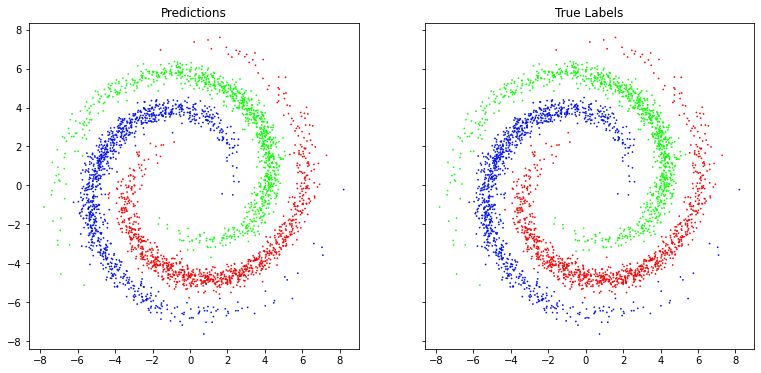

In [18]:
net.accuracy(X_test,Y_test)

labels = net.classify(X_test)
truth = np.argmax(Y_test, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize = (13, 6))
ax1.set_title('Predictions')
plot(X_test, labels, pointsize, ax1)
ax2.set_title('True Labels')
plot(X_test, truth, pointsize, ax2)
plt.show()